In [66]:
import pandas as pd, numpy as np, cvxpy as cvx
import matplotlib.pyplot as plt, scipy.linalg as la

# Abstract
In this report we analyze summary statistic for a number of US equitites and make recommendations based on three different sets of portfolio constraints

# Returns Statistics for Tradable Universe

In [2]:
#pd.read_csv("./MScFE560_FM_GWP1_Data.csv",index_col=0).dropna(how='all',axis=0).dropna(how='all', axis=1)
stats_daily = pd.read_csv("./MScFE560_FM_GWP1_Data.csv",index_col=0).iloc[:4,:5].astype(float).T
stats_daily.columns = ['Mean', 'Vol', 'Skew', 'Kurt']
stats_daily


,Mean,Vol,Skew,Kurt
AAPL,0.044858,0.009320,-0.335173,5.034093
AMZN,0.010362,0.009557,-0.312865,4.729806
NFLX,-0.029675,0.013409,-3.101654,41.968015
META,-0.006934,0.011582,-1.936506,23.289236
GOOG,0.029035,0.008376,-0.197700,4.310171


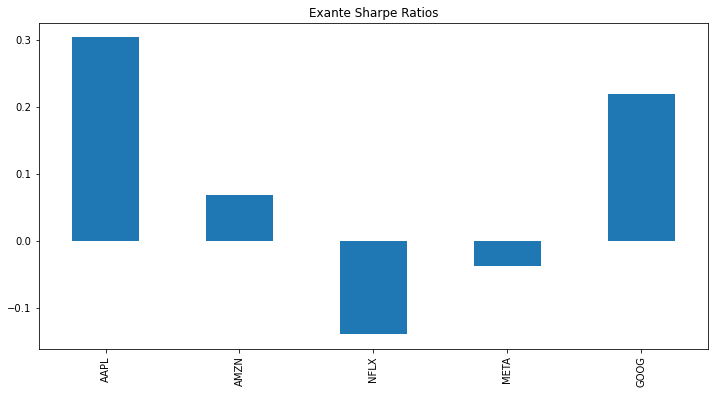

In [276]:
## Here we assume the volatility is daily and the means are annualized
stats_daily.eval('Mean/Vol/sqrt(252)').plot(kind='bar',figsize=(12,6), title='Exante Sharpe Ratios')
corr_daily = pd.read_csv("./MScFE560_FM_GWP1_Data.csv",index_col=0).iloc[6:,:5].astype(float)

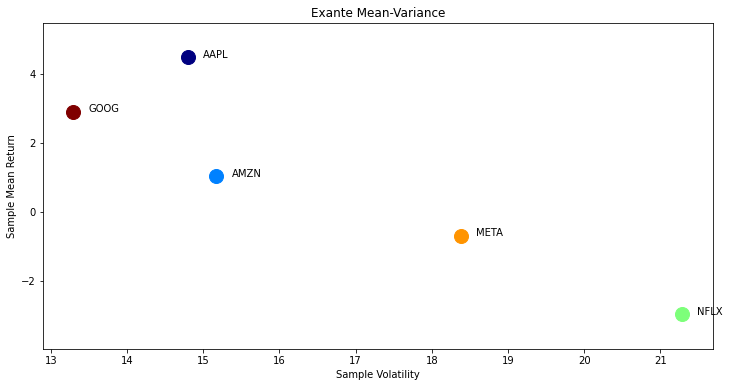

In [266]:
def plot_points(ylim=None):
    """Plot of the exante mean/variance for each stock"""
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    N = 5
    colors = plt.cm.jet(np.linspace(0,1,N))
    x = stats_daily.Vol*100*np.sqrt(252)
    y = stats_daily.Mean*100
    for n,tckr in enumerate(x.index):
        ax.plot(x.iloc[n],    y.iloc[n],'o', color=colors[n], markersize=14)
        ax.text(x.iloc[n]+.2, y.iloc[n], tckr);
    ax.set_title('Exante Mean-Variance')
    ax.set_ylabel('Sample Mean Return'); ax.set_xlabel('Sample Volatility');
    if ylim==None:
        ax.set_ylim(min(y)-1,max(y)+1);
    else:
        ax.set_ylim(min(ylim[0],min(y))-1, max(ylim[1],max(y))+1)
    return ax, x, y
plot_points();

Both from the Sharpe ratios and from the mean-variance plots we can see that AAPL and GOOG standout as good risk reward from the sample statistics provided.

# Portfolio A: Long 1 / Short 1

* We choose to go long GOOG because it has the second best Sharpe ratio, the least negative skew, and kurtosis, and the lowest volatility. Provided that these sample statistics are indicative of its future return distribution this makes GOOG a desireable long position. 

* We choose to short NFLX because it has a non-trivial sample correlation with GOOG (49%), and has the most negative skew, kurtosis, and highest volatility.

* We select the portfolio weights to minimize overall portfolio volatility, i.e., we choose the weight of NFLX using ordinary least squares regression
\begin{align}
    w^\text{NFLX} &= -\frac{\sigma^2(R^\text{NFLX},R^\text{GOOG})}{\sigma^2(R^\text{NFLX})}
\end{align}
where
* $R^i$ is the return of instrument $i$, and
* $\sigma^2(R^i, R^j)$ is the covariance of instruments $i$ and $j$ and $\sigma^2(R^i) = \sigma^2(R^i, R^i)$.

In [267]:
vol = stats_daily.Vol.copy()
Sigma = np.outer(vol.values, vol.values)*corr_daily

w = pd.Series(0,index=vol.index, name='weights')
w['GOOG'] = 1.
w['NFLX'] = -Sigma.loc['NFLX','GOOG']/vol['NFLX']**2
print (f"We go long {w['GOOG']:.2f} units of GOOG and hold {w['NFLX']:.2f} units of NFLX against it. The size of the NFLX position is chosen to minimize volatility.")

We go long 1.00 units of GOOG and hold -0.31 units of NFLX against it. The size of the NFLX position is chosen to minimize volatility.


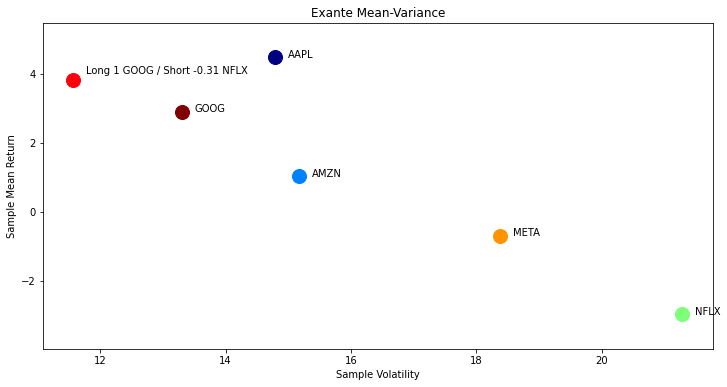

In [268]:
def var_p(w):
    '''Closure used to compute portfolio variance given a Series of instrument weights, w'''
    vol = stats_daily.Vol.copy()
    Sigma = np.outer(vol.values, vol.values)*corr_daily
    return w.dot(Sigma.dot(w))

p = pd.Series({
    'Mean':w.dot(stats_daily.Mean)*100, 
    'Vol': 100*np.sqrt(252)*var_p(w)**.5}, name='Annualized Stats (%)')
p['Exante Sharpe'] = p.Mean/p.Vol

ax,x,y=plot_points()
ax.plot(p.Vol,p.Mean,'o', color='xkcd:bright red', markersize=14)
ax.text(p.Vol + .2,p.Mean+.2, f"Long {w['GOOG']:.0f} GOOG / Short {w['NFLX']:.2f} NFLX");

In [265]:
p.round(2)

Mean              3.82
Vol              11.57
Exante Sharpe     0.33
Name: Annualized Stats (%), dtype: float64

In [275]:
sharpe_single_asset = pd.concat({'Vol':x, 'Mean':y},axis=1).eval('Mean/Vol').sort_values(ascending=False).round(2)
sharpe_single_asset.name = 'Single Asset Sharpe Ratios'
sharpe_single_asset

AAPL    0.30
GOOG    0.22
AMZN    0.07
META   -0.04
NFLX   -0.14
Name: Single Asset Sharpe Ratios, dtype: float64

## Key considerations:

1. *Short Mechanics*: 
    * Note that we should be able to short the NFLX position provided that the total capital allocated to the portfolio isn't too large. For example, if 1,000,000 USD is allocated to the portfolio then we would need to puchase 1 million USD in GOOG shares and borrow 310,000 USD in NFLX shares to go short. The short sale would raise 310,000 USD which could be invested at the risk free rate in order to mitigate the borrow fees.    

2. *Credit Risk* 
    * This portfolio has no credit risk since our only long position is in equities. 

3. *Portfolio Statistics*
    * We can see that the exante portfolio return is 3.82% and the exante portfolio volatility is 11.57% (both annualized).

4. *Diversification*
    * The portfolio is not well diversified, since it is a very concentrated bet on the continued outperformance of GOOG vs NFLX. 

5. Comparing Portfolios
    * Compared to the single asset portfolios the long/short GOOG/NFLX spread portfolio compares favorably. It has lower risk and similar return to AAPL. It has a higher Sharpe ratio than any of the single asset portfolios.

6. Assessing Risk
    * Since this portfolio is a long/short within the internet/tech sector, it represents very concentrated exposure to the idisynchratic risk factors associated with  GOOG and NFLX. Thus, it is difficult to think of a macro-economic risk factors that would negatively affect the spread position; however, there are numerous idiosynchratic scenarios that could affect the spread. For example, Google's advertisement revenue could be reduced by competition from alternative platforms that compete for consumer attention (Twitter, Meta, Instagram, Snapchat, TicTok), whereas Netflix could be hurt by increased competition in generating streaming content.

7. Performance
    * As we have seen during the Covid 19 pandemic, lockdown and work-from-home conditions benefited both companies as consumers had more time and resources to allocate to home entertainment and because they were spending more time online in general. Google (via YouTube) and Netflix are competing for consumer attention and a structural shift in consumer appetites from studio produced content (Netflix) to user produced content would benefit the spread position, while a shift in the opposite direction would negatively affect the spread portfolio. 

8. Disrupters
    * Both companies are long duration technology plays, and thus a more hawkish central bank determined to raise real interest rates in response to high inflation would be a major risk. Higher long duration real discount rates reduces the present value of future dividends that might be expected from both companies and this could affect the quality of the hedge ratio as volatilities would increase significantly and potentially differently for each security. 

9. Re-assessing Risk
    * The portfolio skew should be positive as allocations were chosen to take exposure to the less negatively skewed security (GOOG) and to short the most negatively skewed security (NFLX). 

# Portfolio B: Long Only Portfolio

Portfolios on the mean-variance efficient (MVE) frontier often finance large long positions with large short sales, however, we can impose both a budget and a long only constraint to inform our decision making process. Specifically, we solve the following convex optimization and analyze the resulting solutions on the frontier.

$$
    \max_{w} \left\{ \mu'w - \frac{\gamma}{2} w'\Sigma w \right\}
$$
subject to

\begin{align}
    1'w &= 1 \\
    w &\geq 0
\end{align}

where 
- $\mu$ is an $N\times 1$ vector of asset excess returns
- $\Sigma$ is an $N\times N$ covariance matrix of asset excess returns and
- $\gamma$ is the investor's coefficient of risk aversion. 


We can use the long-only MVE frontier to help inform our portfolio construction decision

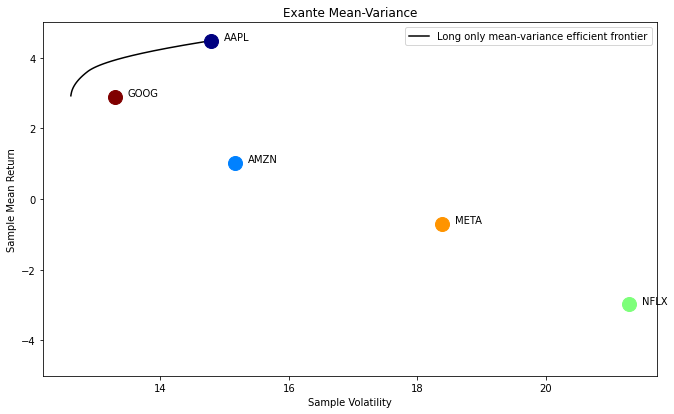

In [252]:
%run ./utils
fig, ax = plt.subplots(1,1,figsize=(11,6.5))

mvf = Frontier(stats_daily, corr_daily, freq=252)

longOnlyOptimize(mvf, gammas = np.logspace(np.log10(0.01),np.log10(100),100))
mvf.plotFrontier(ax=ax,label='Long only mean-variance efficient frontier', points=False, securities=True, color='k')

# ax.plot(p.Vol,p.Mean,'o', color='xkcd:bright red', markersize=14)
# ax.text(p.Vol + .2,p.Mean+.2, f"{w['GOOG']:.0f} GOOG / {w['NFLX']:.2f} NFLX");

ax.legend(loc=0);
ax.set_ylim(-5,5);

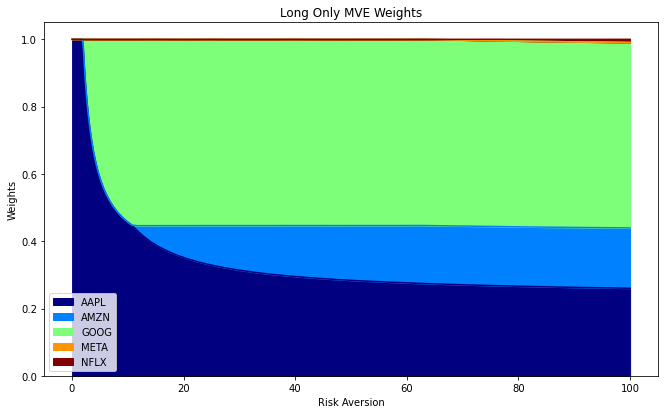

In [256]:
fig, ax = plt.subplots(1,1,figsize=(11,6.5))
mvf.w.T.round(4).plot.area(ax=ax, title='Long Only MVE Weights', cmap='jet')
ax.set_xlabel('Risk Aversion'); ax.set_ylabel('Weights');

Since AAPL and GOOG are relatively efficient with respect to mean, volatility, skew, and kurtosis. We choose a portfolio consisting of 55% GOOG and 45% AAPL.

In [213]:
i = mvf.w.T.idxmax(axis=0)['GOOG']
print(mvf.w.T.loc[i].round(3))

w_lo = pd.Series(0,index=vol.index, name='weights')
w_lo['GOOG'] = .55
w_lo['AAPL'] = .45
w_lo[w_lo!=0]

AAPL    0.430
AMZN    0.016
GOOG    0.554
META   -0.000
NFLX    0.000
Name: 11.768119524349991, dtype: float64


AAPL    0.45
GOOG    0.55
Name: weights, dtype: float64

In [277]:
p_lo

Mean              3.615540
Vol              12.877154
Exante Sharpe     0.280772
Name: Annualized Stats (%), dtype: float64

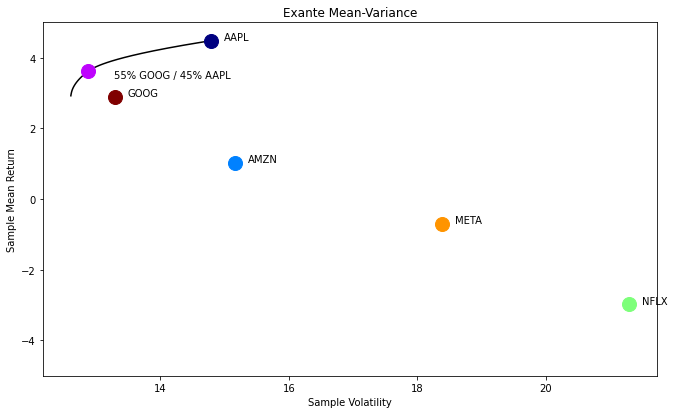

In [261]:
%run ./utils
fig, ax = plt.subplots(1,1,figsize=(11,6.5))

mvf = Frontier(stats_daily, corr_daily, freq=252)

longOnlyOptimize(mvf, gammas = np.logspace(np.log10(0.01),np.log10(100),100))
mvf.plotFrontier(ax=ax,label='Long only mean-variance efficient frontier', points=False, securities=True, color='k')

p_lo= pd.Series({
    'Mean':w_lo.dot(stats_daily.Mean)*100, 
    'Vol': 100*np.sqrt(252)*var_p(w_lo)**.5}, name='Annualized Stats (%)')
p_lo['Exante Sharpe'] = p_lo.Mean/p_lo.Vol

ax.plot(p_lo.Vol,p_lo.Mean,'o', color='xkcd:bright purple', markersize=14)
ax.text(p_lo.Vol + .4,p_lo.Mean-.2, f"{w_lo['GOOG']:.0%} GOOG / {w_lo['AAPL']:.0%} AAPL");
ax.set_ylim(-5,5);

# Portfolio C: Long/Short Three or More Total Positions

We can simply relax the long only constraint in the mean-variance optimization for Portfolio B to generate an efficient frontier that allows for short sales. That is we solve the optimization problem below
$$
    \max_{w} \left\{\mu'w - \frac{\gamma}{2} w'\Sigma w\right\}
$$
subject to
$$
    1'w = 1.
$$

All solutions to the problem above form an efficient frontier in mean-variance (or equivalently mean-volatility) space. It is an interesting fact that if you know the weights for any two (different) portfolios on the frontier, then you can sweep out the entire frontier of efficient portfolios. In particular, all weights on the frontier can be expressed as a linear combination of the maximum Sharpe portfolio and the the minimum-variance portfolio

$$
    w(\alpha) = \alpha \underbrace{\left(\frac{1}{1'\Sigma^{-1}\mu}\Sigma^{-1}\mu\right)}_{\text{Max Sharpe}} 
    + (1-\alpha) \underbrace{\left(\frac{1}{1'\Sigma 1}\Sigma^{-1} 1 \right)}_{\text{Min Vol}}, \quad\quad \text{ for } \alpha \in [0,1]
$$

Since we generally have more confidence in exante estimates of variance/covariance than we do for mean return, we will choose a point near to the minimum variance portfolio, but which satisfies the requirement that we go long and short 3 or more securities, and which is reasonably easy to implement (e.g., low leverage and small shorts).

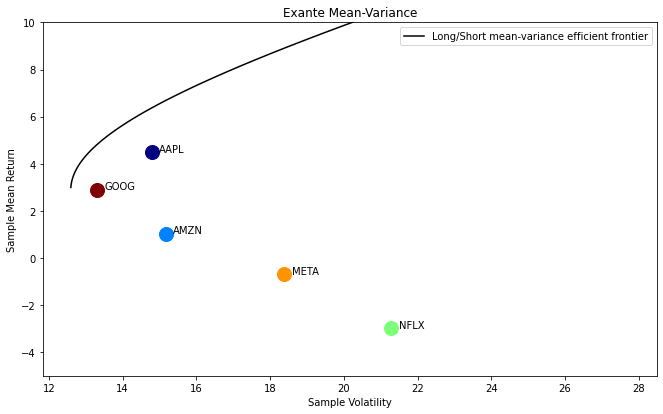

In [246]:
%run ./utils
fig, ax = plt.subplots(1,1,figsize=(11,6.5))

mvf = Frontier(stats_daily, corr_daily, freq=252)

mvOptimize(mvf, gammas = np.logspace(np.log10(0.01),np.log10(1),100), constrained=True)
mvf.plotFrontier(ax=ax,label='Long/Short mean-variance efficient frontier', points=False, securities=True, color='k')


ax.legend(loc=0);
ax.set_ylim(-5,10);

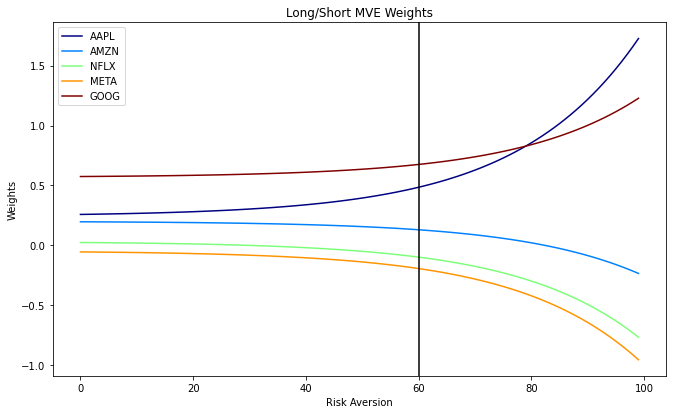

In [248]:
fig, ax = plt.subplots(1,1,figsize=(11,6.5))
mvf.w.T.round(4).plot(ax=ax, title='Long/Short MVE Weights', cmap='jet')
ax.set_xlabel('Risk Aversion'); ax.set_ylabel('Weights');
ax.axvline(60, color='k')
w_ls = mvf.w.T.loc[60]

In [279]:
w_ls.round(2)

AAPL    0.49
AMZN    0.13
NFLX   -0.10
META   -0.19
GOOG    0.68
Name: 60, dtype: float64

The risk aversion coefficient ($\gamma$) of 60 seems to provide a reasonably good trade off between risk, reward, and ease of implementation since the position sizes are all reasonable (as a proportion of total capital).

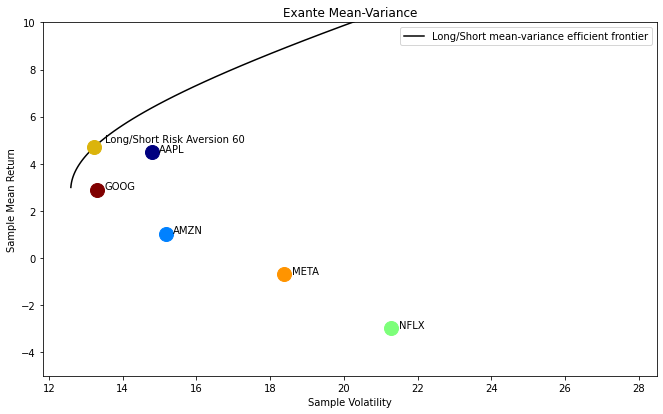

In [251]:
%run ./utils
fig, ax = plt.subplots(1,1,figsize=(11,6.5))

mvf = Frontier(stats_daily, corr_daily, freq=252)

mvOptimize(mvf, gammas = np.logspace(np.log10(0.01),np.log10(1),100), constrained=True)
mvf.plotFrontier(ax=ax,label='Long/Short mean-variance efficient frontier', points=False, securities=True, color='k')

p_ls= pd.Series({
    'Mean':w_ls.dot(stats_daily.Mean)*100, 
    'Vol': 100*np.sqrt(252)*var_p(w_ls)**.5}, name='Annualized Stats (%)')
p_ls['Exante Sharpe'] = p_ls.Mean/p_ls.Vol

ax.plot(p_ls.Vol,p_ls.Mean,'o', color='xkcd:gold', markersize=14)
ax.text(p_ls.Vol + .3,p_ls.Mean+.2, f"Long/Short Risk Aversion 60");

ax.legend(loc=0);
ax.set_ylim(-5,10);

In [280]:
p_ls

Mean              4.696435
Vol              13.221536
Exante Sharpe     0.355211
Name: Annualized Stats (%), dtype: float64

# Step 1

For each investment, you are given statistics in this .csv file the stock’s.
You also have the correlation and covariance matrix of historical returns (download this .csv file)
1. Average return
2. Volatility
3. Skewness
4. Kurtosis

**You must compute the portfolio’s average return and portfolio volatility.**
You do not need to compute the portfolio skewness and portfolio kurtosis.

# Step 2 
Key considerations:
1.  Shorting
    * Can this portfolio be shorted? (Hint: Yes, but be sure to explain part b)
    * If it can be shorted, walk through the mechanics.

2. Credit Risk
    * Does this portfolio have credit risk?
    * If it has credit risk, explain what the credit risk is.

3. Portfolio Statistics
    * Compute the weighted return of the portfolio.
    * Compute the variance of the portfolio.

4. Diversification
    * Describe the diversification in words between the two assets.
    * Do you think this portfolio is well diversified or not?

5. Comparing Portfolios
    * How does your portfolio compare to the others in terms of risk?
    * How does your portfolio compare to the others in terms of return?

6. Assessing Risk
    * Describe economic conditions or scenarios that would affect your security. For example, the COVID-19 pandemic could disrupt travel and halt the production of new aircraft, hurting the demand for airline parts. (Note: this particular example CANNOT be used!)
    * Determine if similar events would hurt one or both members of a portfolio.

7. Performance
    * Now describe economic conditions or scenarios that would greatly
    improve each security. For example, increased business and vacation travel could increase the demand for airline parts (Note: this particular example CANNOT be used!)
    * Determine if similar events would help one or both members of a portfolio.
8. Disrupters
    * List the potential influence the central bank may have on the portfolio.
    * List the potential influence that investment banks may have on the portfolio.

9. Re-assessing Risk
    * Do the two investments in the portfolio have the same skew?
    * Is there a difference between the types of correlation?

# Step 4

Once you have individually finished the analysis of your respective portfolio, get together with your team members and discuss your findings. Think about how the answers to issues like shorting, financing, volatility, correlation, etc., appeal to or discourage potential investors.

For example, discuss these questions:
* How does your portfolio’s volatility compare to the volatility of other portfolios?
* How important is it that your portfolio has high volatility? For example, if your targeted investor base is consevative, you will want lower volatility rather than higher volatility. On the other hand, if your targeted investor base is risk-seeking, you may want to recommend the portfolio with higher volatility.

# Step 5

As a group, write the two items described below. These investors understand fundamental principles of return and risk for individual securities but need to understand those concepts as they pertain to the specific portfolio:

    1. Write a marketing piece to promote the advantages of one of the portfolios. Based on the conversation you’ve had as a team, be sure to explain why it is better than the other portfolio. Length: 1 slide (PPT or Google Sheets)
    
    2. Write an email to discourage someone from investing in one of the portfolios. Based on the conversation you’ve had as a team, be sure to explain how there may be better portfolios out there. Length: 250-300 words

Note: In each piece, be sure to use terms discussed in the notes, including: 
* Shorting
* Financing
* Volatility
* Correlation
